![](https://drive.google.com/uc?export=view&id=1-5X9OUkA-C2Ih1gOS9Jd7GmkTWUEpDg1)

# Laboratorio: GAN (Generative Adversarial Nets)

## _Deep learning_
   
<center>
    <img src='images/GAN.jpeg'style="width: 600px;">
</center>

**Profesor**: Juan Bekios Calfa

**Carreras**: ICCI, IECI e IenCI

<sub><sup>Tutorial: GANS. Sensio Artificial Intelligence [link](https://sensioai.com/blog/051_gans)</sup></sub> 

## Introducción

GANs (_generative adversarial networks_) es una arquitectura de red neuronal propuesta en 2014 por Ian Goodfellow y otros con el objetivo de obtener modelos capaces de generar datos realistas, principalmente imágenes. 

Pese a la simplicidad de la idea original, se tardó varios años en superar varias de las dificultades que presenta su entrenamiento. Hoy en día, sin embargo, se utilizan para obtener resultados espectaculares. 

## Arquitectura

La arquitectura básica de las GANs está formada por dos redes neuronales:

* **El generador**: recibe a la entrada valores aleatorios (normalmente obtenidos de una distribución de tipo gausiana) y da a la salida una imagen. Puedes ver la entrada aleatoria como una representación latente (o codificación) de la imagen generada.
* **El discriminador**: recibe a la entrada una imagen (real o generada por el generador) y tiene que decidir si bien la imagen es real o falsa.



## Arquitectura

<center>
    <img src='images/fig-gan.png'style="width: 1200px;">
</center>


## Entrenamiento

Para poder entrenar una GAN:

* En una **primera fase**, entrenamos el discriminador. En cada iteración, le daremos un batch compuesto de imágenes reales obtenidas del dataset e imágenes falsas generadas por el generador. Definiremos un conjunto de etiquetas a 0 para las imágenes falsas y 1 para las reales. Entonces, optimizaremos el discriminador (utilizando una función de pérdida de tipo binary cross-entropy mejorando así sus capacidades de distinguir imágenes falsas de reales.
* En la **segunda fase**, entrenamos el generador. En cada iteración, le daremos un batch compuesto de ruido aleatorio para que genere imágenes. Estas imágenes son introducidas en el discriminador, cuyas salidas (etiquetas real/falso) son comparadas con un conjunto de etiquetas definidas como reales. Entonces, optimizaremos el generador (utilizando de nuevo la misma función de pérdida) de manera que el generador actualizará sus pesos para generar imágenes que engañen al discriminador.


## GAN simple

Vamos a ver cómo podemos implementar esta arquitectura y proceso de entrenamiento con la implementación de una GAN muy simple para generar imágenes del _dataset Fashion MNIST_.

In [43]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
device 

'cuda'

In [46]:
# Cargar el conjunto de entrenamiento
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)

classes = ("t-shirt", "trousers", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot")

In [47]:
import numpy as np

class Dataset(torch.utils.data.Dataset):
  def __init__(self, trainset):
    self.imgs = torch.tensor([np.array(i[0]).flatten() / 255. for i in trainset], dtype=torch.float, device=device)
    self.labels = torch.tensor([i[1] for i in trainset], dtype=torch.long, device=device)

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, ix):
    return self.imgs[ix], self.labels[ix]

train = Dataset(trainset)
len(train)

60000

In [49]:
img, label = train[0]
img.shape, img.dtype, img.max(), img.min()

(torch.Size([784]),
 torch.float32,
 tensor(1., device='cuda:0'),
 tensor(0., device='cuda:0'))

In [50]:
dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)

imgs, labels = next(iter(dataloader))
imgs.shape, labels.shape

(torch.Size([32, 784]), torch.Size([32]))

## Dataset

La base de datos está formado por **60000 imágenes** de baja resolución (**28 x 28 píxeles**, en blanco y negro) y contiene 10 tipos prendas de ropa (camisetas, pantalones, etc).

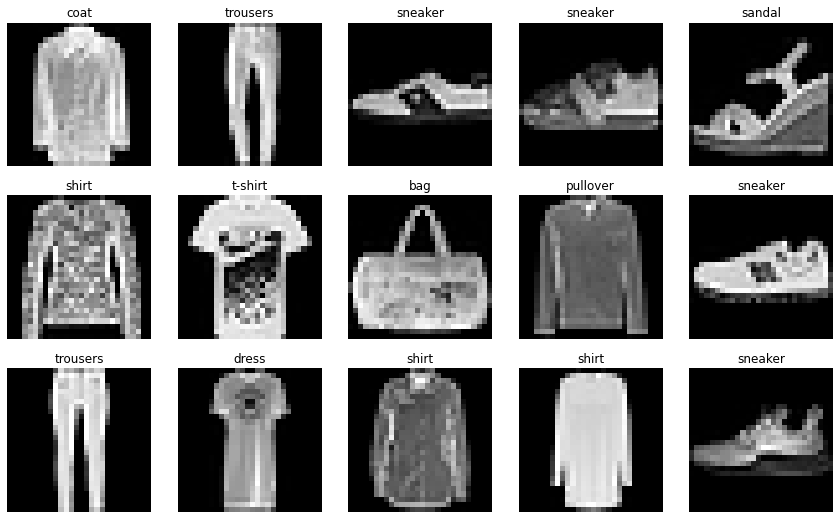

In [51]:
import random 
import matplotlib.pyplot as plt

r, c = 3, 5
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(train)-1)
        img, label = train[ix]
        plt.imshow(img.reshape(28,28).cpu(), cmap='gray')
        plt.axis('off')
        plt.title(classes[label.item()])
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

## Implementación GAN simple

El objetivo es entrenar una GAN que sea capaz de generar imágenes similares a las que tenemos en la base de datos a partir de valores aleatorios (ruido). 

Se implementará **un generador** y **un discriminador**. Para esta implementación simple usaremos la misma arquitectura para ambas redes, un **Perceptrón Multicapa (MLP)**.

In [ ]:
import torch.nn as nn

def block(n_in, n_out):
  return nn.Sequential(
      nn.Linear(n_in, n_out),
      nn.ReLU(inplace=True)
  )

class MLP(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.input_size = input_size
    self.fc1 = block(input_size, 150)
    self.fc2 = block(150, 100)
    self.fc3 = nn.Linear(100, output_size)

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    return x

## Arquitectura

La **red neuronal multicapa** está formado por 3 capas lineales (cada capa seguida de una activación relu). En función del número de entradas y salidas definiremos las diferentes redes. Por ejemplo, el generador recibirá un vector con 30 valores aleatorios y nos dará a la salida un vector de 28 x 28 valores (igual que las imágenes del dataset).

### Generador

In [52]:
n_in, n_out = 30, 28*28
generator = MLP(n_in, n_out)

### Generador inicializado

Como los pesos son aleatorios y no han sido entrenados. Si probamos con una **entrada aleatoria** la **salida esperada** será una **imagen con ruido**.

In [53]:
output = generator(torch.randn(64, 30))
output.shape

torch.Size([64, 784])

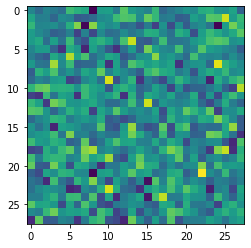

In [56]:
plt.imshow(output[40].reshape(28,28).detach().numpy())
plt.show()

### Discriminador

Recibirá a la entrada una imagen (28 x 28 valores) y a la salida nos dará una clasificación binaria (real o falso).

In [57]:
discriminator = MLP(28*28, 1)
output = discriminator(torch.randn(64, 28*28))
output.shape

torch.Size([64, 1])

## Entrenando ambas redes

In [59]:
from fastprogress import master_bar, progress_bar

def fit(g, d, dataloader, epochs=30, crit=None):
  g.to(device)
  d.to(device)
  g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)
  d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)
  crit = nn.BCEWithLogitsLoss() if crit == None else crit
  g_loss, d_loss = [], []
  mb = master_bar(range(1, epochs+1))
  hist = {'g_loss': [], 'd_loss': []}
  for epoch in mb:
    for X, y in progress_bar(dataloader, parent=mb):
      #X, y = X.to(device), y.to(device)  
      # entrenamos el discriminador
      g.eval()
      d.train()
      #   generamos un batch de imágenes falsas
      noise = torch.randn((X.size(0), g.input_size)).to(device)
      genenerated_images = g(noise)
      #   input del discrminator
      d_input = torch.cat([genenerated_images, X.view(X.size(0), -1)])
      #   gorund truth para el discriminator
      d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1,1).to(device)
      #   optimización
      d_optimizer.zero_grad()
      d_output = d(d_input)
      d_l = crit(d_output, d_gt)
      d_l.backward()
      d_optimizer.step()
      d_loss.append(d_l.item())
      # entrenamos el generador
      g.train()
      d.eval()
      #   generamos un batch de imágenes falsas
      noise = torch.randn((X.size(0), g.input_size)).to(device)
      genenerated_images = g(noise)
      #   salidas del discriminador
      d_output = d(genenerated_images)
      #   gorund truth para el generator
      g_gt = torch.ones(X.size(0)).view(-1,1).to(device)
      #   optimización
      g_optimizer.zero_grad()
      g_l = crit(d_output, g_gt)
      g_l.backward()
      g_optimizer.step()
      g_loss.append(g_l.item())
      # logs
      mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
    mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
    hist['g_loss'].append(np.mean(g_loss))    
    hist['d_loss'].append(np.mean(d_loss))
  return hist

## Ejecutamos el entrenamiento de la red

In [60]:
hist = fit(generator, discriminator, dataloader)

## Visualización de las pérdidas en el entrenamiento

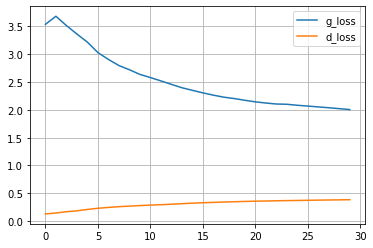

In [61]:
import pandas as pd 

df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

## Probando generador entrenado

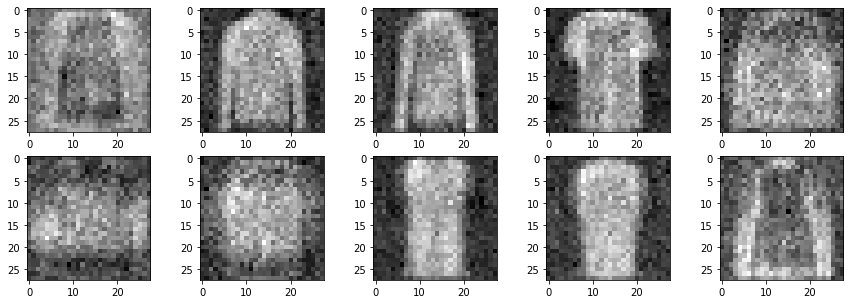

In [63]:
generator.eval()
with torch.no_grad():
  noise = torch.randn((10, generator.input_size)).to(device)
  generated_images = generator(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,5))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = generated_images[i].view(28,28).cpu()
      _ax.imshow(img, cmap='gray')
      i+=1
  plt.show()

## DCGANs

Podemos usar **DCGANs** (_deep convolutional GANs_) para obtener mejores generadores utilizando redes convolucionales. En este caso, necesitaremos arquitecturas diferentes para generador y discriminador.

<center>
    <img src='images/dcgan.png'style="width: 900px;">
</center>


## Arquitecura

El **generador** recibirá un vector de 100 valores aleatorios y después aplicaremos varias capas de convoluciones transpuestas (que aumentarán el tamaño de los mapas de caracterísitcas, como vimos en las redes para segmentación) hasta obtener la imagen generada.

In [64]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.input_size = 100
    self.inp = nn.Sequential(
        nn.Linear(self.input_size, 7*7*128),
        nn.BatchNorm1d(7*7*128),
    )
    self.main = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1, bias=False),
        nn.Tanh()
    )

  def forward(self, x):
    x = self.inp(x)
    x = x.view(-1, 128, 7, 7)
    x = self.main(x)
    x = x.view(x.size(0), 28*28)
    return x

### Configurando el generador

In [66]:
generator = Generator()
output = generator(torch.randn(64, 100))
output.shape

torch.Size([64, 784])

Al final del generador usamos una activación **tanh**, que dará valores entre -1 y 1. Por este motivo tenemos que **re-normalizar nuestras imágenes en el dataset**.

In [67]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, trainset):
    self.imgs = torch.tensor([np.array(i[0]).flatten() / 255. for i in trainset], dtype=torch.float, device=device)
    self.imgs = self.imgs * 2. - 1.
    self.labels = torch.tensor([i[1] for i in trainset], dtype=torch.long, device=device)

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, ix):
    return self.imgs[ix], self.labels[ix]

train = Dataset(trainset)
len(train)

60000

In [69]:
img, label = train[0]
img.shape, img.dtype, img.max(), img.min()

(torch.Size([784]),
 torch.float32,
 tensor(1., device='cuda:0'),
 tensor(-1., device='cuda:0'))

In [70]:
dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)

imgs, labels = next(iter(dataloader))
imgs.shape, labels.shape

(torch.Size([32, 784]), torch.Size([32]))

### Discriminador

Usaremos CNN típica como las que conocemos cuando trabajamos en clasificación de imágenes.

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.main = nn.Sequential(
        nn.Conv2d(1, 64, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True)
    )
    self.out = nn.Sequential(
        nn.Linear(128*7*7, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    # esperamos vectores a la entrada de 28*28
    x = x.view(x.size(0), 1, 28, 28)
    x = self.main(x)
    x = x.view(x.size(0), -1)
    x = self.out(x)
    return x

In [71]:
discriminator = Discriminator()
output = discriminator(torch.randn(64, 28*28))
output.shape

torch.Size([64, 1])

## Entrenamos la red

In [72]:
hist = fit(generator, discriminator, dataloader, crit=torch.nn.BCELoss())

## Visualizamos la pérdida del modelo para el generador y el discriminador

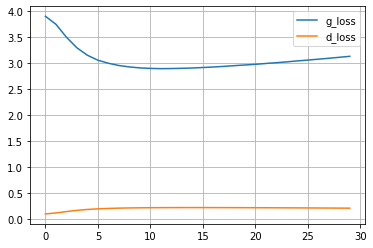

In [73]:
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

## Revisamos los modelos generados

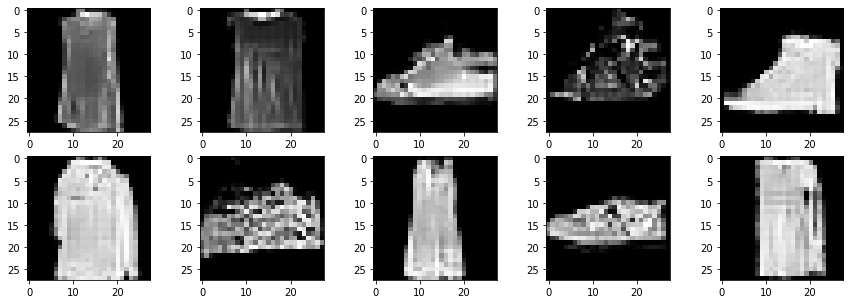

In [76]:
generator.eval()
with torch.no_grad():
  noise = torch.randn((10, generator.input_size)).to(device)
  generated_images = generator(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,5))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = generated_images[i].view(28,28).cpu()
      _ax.imshow(img, cmap='gray')
      i+=1
  plt.show()